In [1]:
import fasr_solar_simul as fss
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.constants import c
import os
from casatasks import tclean, applycal, clearcal
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
from astropy.time import Time
from sunpy import coordinates

# Speed of light in m/s
C_LIGHT = c
import matplotlib
%matplotlib inline

In [2]:
from importlib import reload

reload(fss)
target = 'Quiet_Sun'
figsubfolder = 'figs/'
model_dir = '../fasr_sim/skymodels/quiet_sun/'

In [95]:
# List of all available frequencies in GHz
freq_list = ['1GHz', '2GHz', '5GHz', '10GHz', '20GHz']
imsizes = [512, 512, 1024, 2048, 4096]
cells = ['4.8arcsec', '4.8arcsec', '2.4arcsec', '1.2arcsec', '0.6arcsec']
scales = [[0, 5, 10, 50], [0, 4, 10, 40], [0, 6, 20, 80], [0, 5, 10, 40, 160], [0, 10, 40, 80, 320]]

freq_init = freq_list[1]
imsize_init = imsizes[1]
cell_init = cells[1]
scale_init = scales[1]

freq_target = freq_list[2]
imsize_target = imsizes[2]
cell_target = cells[2]
scale_target = scales[2]

# List of configurations
project = 'FASR-A'
config_file = 'fasr-a_random_spiral_hybrid_120.cfg'

## Antenna temperature noise levels
tsys = 300.  # System temperature in K

## Define the fractional gain errors tuples: (phase and amplitude)
# 6 degrees (or 1.7% of phase error is equivalent to 10% of amplitude error )
#cal_errors = [(0., 0.), (0.017, 0.1)]
cal_errors = [(0., 0.)]

# Define channel width and integration time
channel_width_mhz = 24. # channel width in MHz
integration_time = 1. # Time per integration in seconds
duration = 1. # Total imaging duration in seconds

# Reference timestamp for the observation series
reftime='2020-11-26T20:45:47'
solar_radius_asec = coordinates.sun.angular_radius(reftime).value

# Flags to control overwriting existing data products
overwrite_ms   = False  # Overwrite measurement set?
overwrite_im   = False  # Overwrite image products?
overwrite_plot = True  # Overwrite existing plots?

weighting = 'uniform'
# Deconvolution algorithm choice
#deconvolver = 'hogbom'
#niter = 0

deconvolver = 'multiscale'
niter = 10000

## Generate measurement sets at 2 GHz without any calibration errors

In [96]:
%matplotlib inline
reload(fss)
import time

reftime_casa = Time(reftime).strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder)
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
caltbdir = os.path.join(project, 'caltbs')
if not os.path.exists(caltbdir):
    os.makedirs(caltbdir)
    
cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
solar_model = f'{model_dir}/solar_disk_model_20201126.{freq_init}.masked.fits'
# Calculate theoretical sensitivity with natural weighting
antenna_params = np.genfromtxt(config_file, comments='#')
dish_diameter = antenna_params[0, 3]
uv_cell = 1. / (imsize_init * float(cell_init.rstrip('arcsec')) / 206265.)
total_flux = fss.calc_total_flux_on_dish(solar_model, dish_diameter=dish_diameter, freqghz=freq_init)
tant = fss.total_flux_to_tant(total_flux, eta_a=0.6, dish_diameter=dish_diameter)
print(f'Tant: {tant:.0f}K')
noisejy, sigma_na, sigma_un = fss.calc_noise(tsys, config_file, dish_diameter=dish_diameter, 
                                             total_flux=total_flux, duration=duration,
                                             integration_time=integration_time, 
                                             channel_width_mhz=channel_width_mhz, 
                                             freqghz=freq_init, uv_cell=uv_cell)
sigma_jy = sigma_un / np.sqrt((duration / integration_time))
    
for phaerr, amperr in cal_errors:
    phaerr_deg = np.rad2deg(phaerr)
    gaintable = [f'caltb_FASR_corrupt_{phaerr_deg:.0f}deg.ph',
                 f'caltb_FASR_corrupt_{np.int_(amperr * 100)}pct.amp']
    msname_init = fss.make_msname(project, target, freq_init, Time(reftime).datetime, duration, integration_time, config_file, tsys)
    imname_init = fss.make_imname(msname_init, deconvolver, phaerr, amperr)
    if niter == 0:
        imname_init = imname_init.replace(deconvolver, 'dirty')
    msfile_init = f'{msname_init}.ms'
    if os.path.exists(msfile_init):
        if overwrite_ms:
            os.system('rm -rf ' + msfile_init)
        else:
            pass
    
    if not os.path.exists(msfile_init):
        print('Start generating ms')
        msfile_init = fss.generate_ms(config_file, solar_model, reftime_casa, freq_init, integration_time=integration_time,
                        duration=duration, channel_width_mhz=channel_width_mhz, 
                        msname=msfile_init, tsys=tsys, usehourangle=True)
    else:
        print(f'Measurement set {msfile_init} already exists. Skipping MS generation.')

Total flux within primary beam used to calcuate the antenna temperature: 29.4 sfu
Tant: 113K
29.432328125
Calculate antenna temperature from total flux 29.432328125 sfu incident on the dish
Total noise temperature (K): 4.130e+02 K
Estimated SEFD: 1.156e+06 Jy
Estimated natural weighting point source sensitivity sigma_na: 1.396e+00 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 1.847e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 1.669e+02 Jy for 7140 baselines
Measurement set FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K.ms already exists. Skipping MS generation.


In [97]:
print('msfile_init:', msfile_init)
print('imname_init:', imname_init)

msfile_init: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K.ms
imname_init: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale


2026-02-05 14:50:14	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-05 14:50:14	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-05 14:50:14	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 
2026-02-05 14:50:14	WARN	task_tclean::SDAlgorithmMSClean::takeOneStep (file src/code/synthesis/ImagerObjects/SDAlgorithmMSClean.cc, line 185)	MSClean minor cycle stopped at large scale negative or diverging
2026-02-05 14:50:18	WARN	SDAlgorithmMSClean::takeOneStep (file src/code/synthesis/ImagerObjects/SDAlgorithmMSClean.cc, line 185)	MSClean minor cycle stopped at large scale negative or diverging
2026-02-05 14:50:22	WAR

deconvolution completed in 3.06 minutes


(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

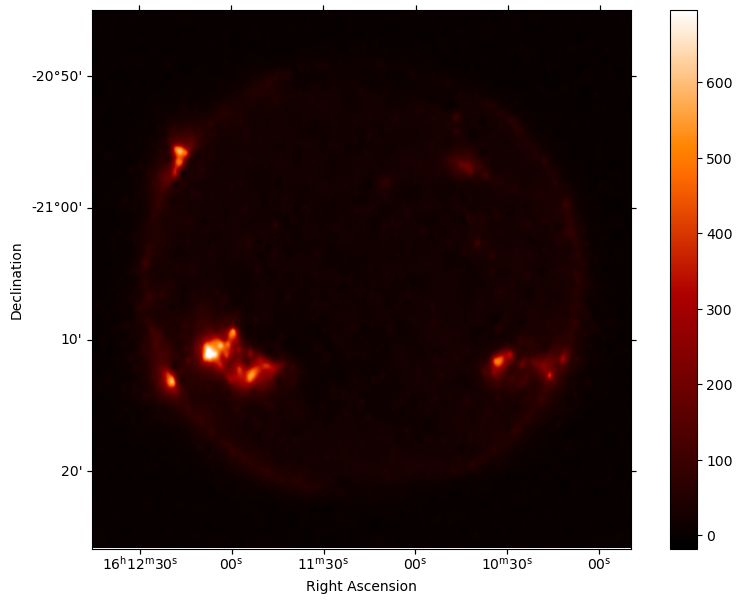

In [98]:
# now make a clean image from the generated MS without any calibration errors
reload(fss)
if not os.path.exists(f'{imname_init}.image'):
    tstart = time.time()
    if deconvolver == 'hogbom':
        tclean(vis=msfile_init, imagename=imname_init,
               datacolumn='corrected',
               field='', spw='', specmode='mfs', 
               deconvolver=deconvolver, pblimit=0.01,
               imsize=imsize, cell=cell,
               weighting=weighting,
               niter=niter,
               interactive=False)
    elif deconvolver == 'multiscale':
        tclean(vis=msfile_init, imagename=imname_init,
               datacolumn='corrected',
               field='', spw='', specmode='mfs', 
               deconvolver=deconvolver, scales=scale_init, 
               gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
               imsize=imsize_init, cell=cell_init,
               weighting=weighting,
               niter=niter,
               interactive=False)                        
    junk = ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
    for j in junk:
        os.system(f'rm -rf {imname_init}{j}')
    tend = time.time()
    print(f'deconvolution completed in {(tend - tstart)/60.:.2f} minutes')
else:
    print(f'Image {imname_init}.image already exists. Skipping imaging.')

fss.plot_casa_image(imname_init + '.image', cmap='hinodexrt')

## Generate measurement sets at 5 GHz with calibration errors

In [156]:
%matplotlib inline
reload(fss)
from casatasks import split
import time

# add 10% phase (of a radian) and 10% amplitude errors
cal_errors = [(0.1, 0.1)]

reftime_casa = Time(reftime).strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder)
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
caltbdir = os.path.join(project, 'caltbs')
if not os.path.exists(caltbdir):
    os.makedirs(caltbdir)
    
cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
solar_model = f'{model_dir}/solar_disk_model_20201126.{freq_target}.masked.fits'
# Calculate theoretical sensitivity with natural weighting
antenna_params = np.genfromtxt(config_file, comments='#')
dish_diameter = antenna_params[0, 3]
uv_cell = 1. / (imsize_target * float(cell_target.rstrip('arcsec')) / 206265.)
total_flux = fss.calc_total_flux_on_dish(solar_model, dish_diameter=dish_diameter, freqghz=freq_target)
tant = fss.total_flux_to_tant(total_flux, eta_a=0.6, dish_diameter=dish_diameter)
print(f'Tant: {tant:.0f}K')
noisejy, sigma_na, sigma_un = fss.calc_noise(tsys, config_file, dish_diameter=dish_diameter, 
                                             total_flux=total_flux, duration=duration,
                                             integration_time=integration_time, 
                                             channel_width_mhz=channel_width_mhz, 
                                             freqghz=freq_target, uv_cell=uv_cell)
sigma_jy = sigma_un / np.sqrt((duration / integration_time))
    
for phaerr, amperr in cal_errors:
    phaerr_deg = np.rad2deg(phaerr)
    gaintable = [f'caltb_FASR_corrupt_{phaerr_deg:.0f}deg.ph',
                 f'caltb_FASR_corrupt_{np.int_(amperr * 100)}pct.amp']
    msname = fss.make_msname(project, target, freq_target, Time(reftime).datetime, duration, integration_time, config_file, tsys)
    imname = fss.make_imname(msname, deconvolver, phaerr, amperr)
    if niter == 0:
        imname = imname.replace(deconvolver, 'dirty')
    msfile = f'{msname}.ms'
    if os.path.exists(msfile):
        if overwrite_ms:
            os.system('rm -rf ' + msfile)
        else:
            pass
    
    if not os.path.exists(msfile):
        print('Start generating ms')
        msfile = fss.generate_ms(config_file, solar_model, reftime_casa, freq_target, integration_time=integration_time,
                        duration=duration, channel_width_mhz=channel_width_mhz, 
                        msname=msfile, tsys=tsys, usehourangle=True)
    else:
        print(f'Measurement set {msfile} already exists. Skipping MS generation.')
    
    gaintable = fss.generate_caltb(msfile, caltype=['ph', 'amp'], 
                                   calerr=[phaerr, amperr], caltbdir=caltbdir)
    clearcal(vis=msfile)
    # Now apply calibration
    print('Applying calibration')
    applycal(vis=msfile, gaintable=gaintable, applymode='calonly', calwt=False)
    # split the ms after applying calibration

ms_corrupted = msfile.replace('.ms', '_corrupt.ms')
if not os.path.exists(ms_corrupted):
    split(vis=msfile, outputvis=ms_corrupted, datacolumn='corrected')
    print('Split corrupted data into new MS:', ms_corrupted)

Total flux within primary beam used to calcuate the antenna temperature: 78.1 sfu
Tant: 300K
78.147675
Calculate antenna temperature from total flux 78.147675 sfu incident on the dish
Total noise temperature (K): 6.001e+02 K
Estimated SEFD: 1.680e+06 Jy
Estimated natural weighting point source sensitivity sigma_na: 2.029e+00 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 2.270e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 2.424e+02 Jy for 7140 baselines
Measurement set FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K.ms already exists. Skipping MS generation.
Generated phase calibration table: FASR-A/caltbs/caltb_FASR_corrupt_6deg.ph
Generated amplitude calibration table: FASR-A/caltbs/caltb_FASR_corrupt_10pct.amp
Applying calibration


2026-02-05 19:32:52	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Opening calibration table: FASR-A/caltbs/caltb_FASR_corrupt_6deg.ph
Shape of the data in FASR-A/caltbs/caltb_FASR_corrupt_6deg.ph: (2, 1, 120)


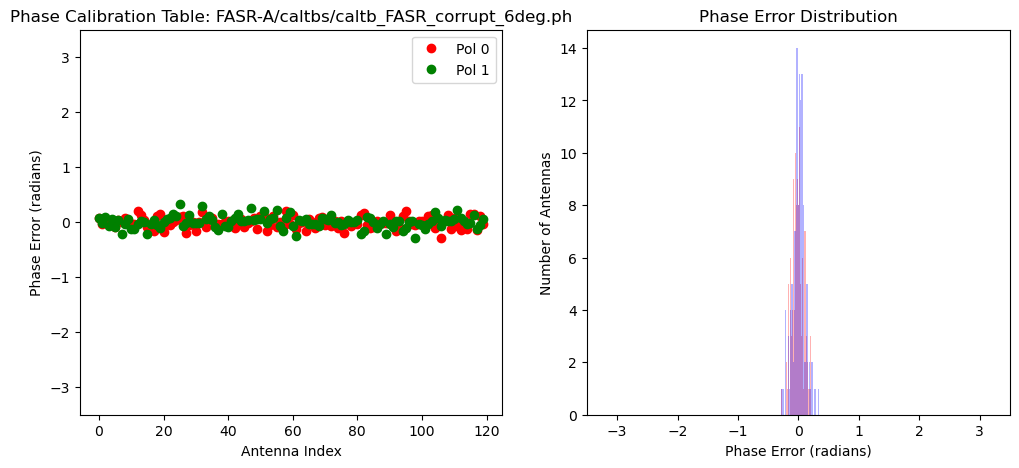

Opening calibration table: FASR-A/caltbs/caltb_FASR_corrupt_10pct.amp
Shape of the data in FASR-A/caltbs/caltb_FASR_corrupt_10pct.amp: (2, 1, 120)


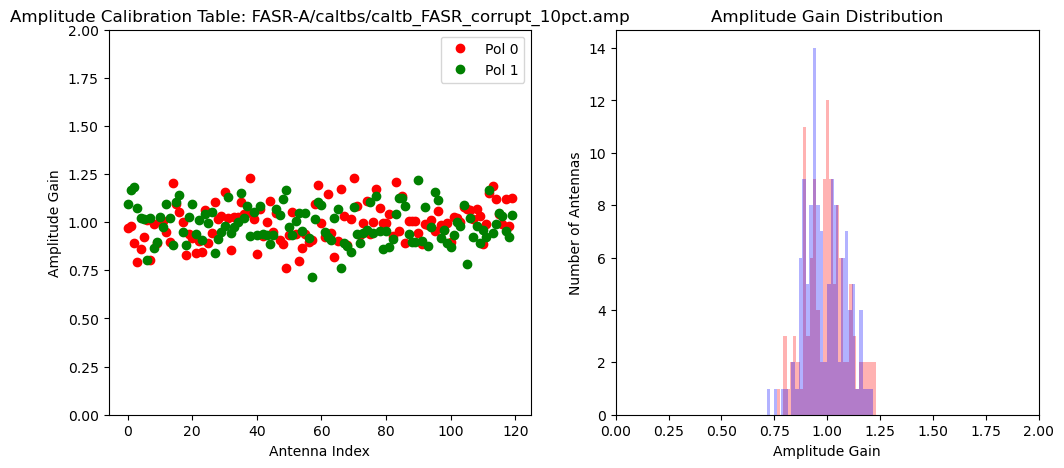

In [149]:
reload(fss)
fss.plot_caltb_stats(gaintable[0], caltype='ph', yrange=[-3.5, 3.5])
fss.plot_caltb_stats(gaintable[1], caltype='amp', yrange=[0, 2])

(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

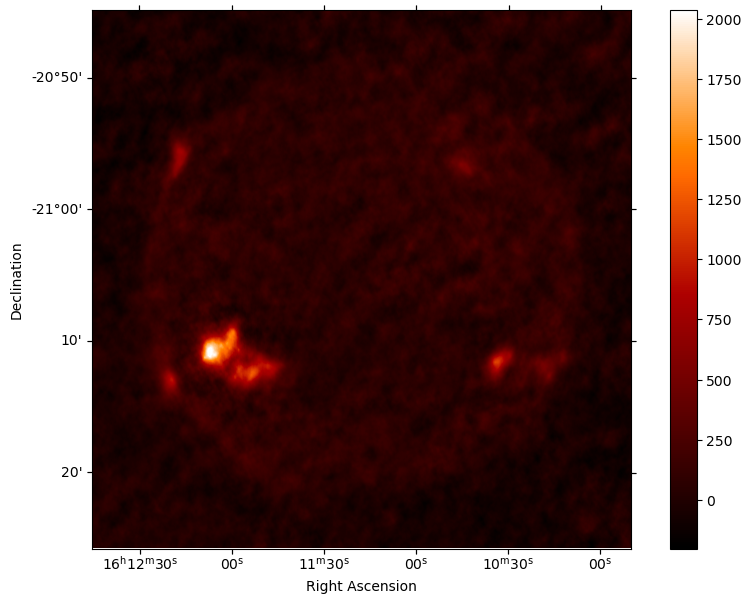

In [159]:
# Make a dirty image from the corrupted MS
imname_dirty = imname.replace(deconvolver, 'dirty')
if not os.path.exists(f'{imname_dirty}.image'):
    tclean(vis=ms_corrupted,
           imagename=imname_dirty,
           imsize=imsize_target,
           cell=cell_target,
           weighting=weighting,
           deconvolver='hogbom',
           niter=0,
           interactive=False,
           savemodel='none')
    print('Dirty image created:', imname_dirty)
    # clean up intermediate files
    for suffix in ['.model', '.residual', '.psf', '.flux',
                     '.mask', '.pb', '.image.pbcor', '.sumwt']:
          file_to_remove = f'{imname_dirty}{suffix}'
          if os.path.exists(file_to_remove):
                os.system(f'rm -rf {file_to_remove}')
                print('Removed intermediate file:', file_to_remove)
fss.plot_casa_image(imname_dirty + '.image', cmap='hinodexrt')

FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_clean


2026-02-05 20:13:53	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-05 20:13:53	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-05 20:13:53	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 
2026-02-05 20:17:59	WARN	SDAlgorithmMSClean::takeOneStep (file src/code/synthesis/ImagerObjects/SDAlgorithmMSClean.cc, line 185)	MSClean minor cycle stopped at large scale negative or diverging
2026-02-05 20:19:16	WARN	SDAlgorithmMSClean::takeOneStep (file src/code/synthesis/ImagerObjects/SDAlgorithmMSClean.cc, line 185)	MSClean minor cycle stopped at large scale negative or diverging
2026-02-05 20:19:30	WARN	SDAlgorithm

image created: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_clean
Start plotting
Applying a mask of 1.3 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_clean.image: 3.049e+05 K
rms of fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_clean.image (excluding solar disk): 2.603e+03 K
SNR of the image: 117.1
Peak of solar_disk_model_20201126.5GHz.masked.im: 3.226e+05 K
rms of solar_disk_model_20201126.5GHz.masked.im (excluding solar disk): 5.104e-03 K
Plotting image with vmin=-2.603e+04 K, vmax=1.525e+05 K
Plotting convolved image with vmin=-2.603e+04 K, vmax=1.525e+05 K


/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2880: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2925: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)


'plot_two_casa_images_with_convolution' completed at 2026-02-05 15:25:02; runtime: 0.81 seconds


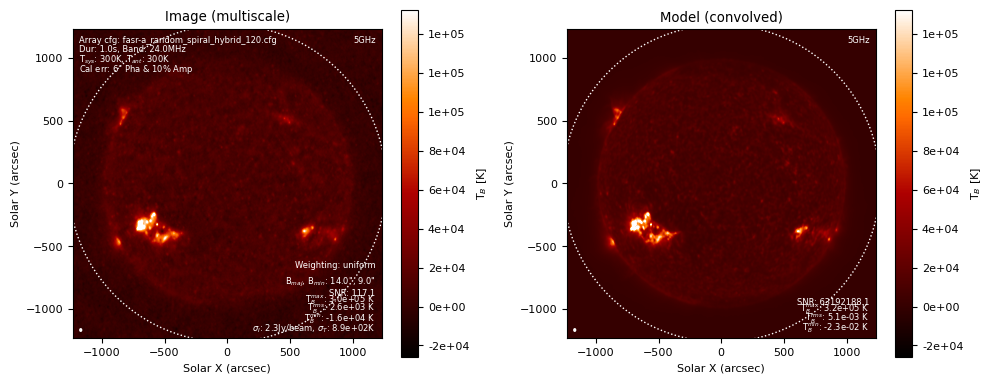

In [203]:
# make a clean image from the corrupted MS
imname_clean = imname + '_clean'
print(imname_clean)
if not os.path.exists(f'{imname_clean}.image'):
    tclean(vis=ms_corrupted,
           imagename=imname_clean,
           imsize=imsize_target,
           cell=cell_target,
           weighting=weighting,
           deconvolver='multiscale', scales=scale_init, 
           gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
           #deconvolver='hogbom',
           niter=10000,
           interactive=False,
           savemodel='modelcolumn')
    print('image created:', imname_clean)
    # clean up intermediate files
    for suffix in ['.model', '.residual', '.psf', '.flux',
                     '.mask', '.pb', '.image.pbcor', '.sumwt']:
          file_to_remove = f'{imname_clean}{suffix}'
          if os.path.exists(file_to_remove):
                os.system(f'rm -rf {file_to_remove}')
            
#fss.plot_casa_image(imname_clean + '.image', cmap='hinodexrt')
image1 = imname_clean + '.image'
## model image
image2 = os.path.join(project+'/msfiles/Quiet_Sun/', os.path.basename(solar_model.replace('.fits', '.im')))
image_meta = {'title': [f'Image ({deconvolver})', 'Model (convolved)'],
              'freq': freq_target.lstrip("0"),
              'array_config': config_file,
              'tsys': f'{tsys:.0f}K',
              'tant': f'{tant:.0f}K',
              'sigma_jy': f'{sigma_jy:.1f}Jy/beam',
              'cal_error': f'{phaerr_deg:.0f}'+r'$^{\circ}$ Pha' + f' & {np.int_(amperr * 100)}% Amp',
              'duration': f'{duration}s',
              'bandwidth': f'{channel_width_mhz}MHz',
              'weighting': weighting,
              }
print('Start plotting')
fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                     crop_fraction=(0.0, 1.0),
                                                     #crop_fraction=((0.17, 0.37), (0.25, 0.45)),
                                                     rms_mask_radius=1.3,
                                                     reftime=reftime,
                                                     figsize=(15, 4),
                                                     image_meta=image_meta,
                                                     cmap='hinodexrt',
                                                     vmax=50,
                                                     compare_two=False,
                                                     contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4,
                                                                     0.8],
                                                     conv_tag=f'.{cfg_suffix}',
                                                     overwrite_conv=False)
#figname = os.path.join(figdir, f'fig-{os.path.basename(imname_clean)}.jpg')
#fig.savefig(figname, dpi=300)

In [190]:
# Put the model image into the model column of the MS
from casatasks import ft
from casatasks import gaincal
clearcal(vis=ms_corrupted)
ft(vis=ms_corrupted, spw='0', model=imname_clean+'.image', usescratch=False)
# Perform phase-only self-calibration
cal_table_selfcal_p = imname + '_selfcal0.p'
cal_table_selfcal_a = imname + '_selfcal0.a'
uvrange = '<20klambda' # exclude longest baselines for self-calibration to avoid overfitting noise
gaincal(vis=ms_corrupted,
        caltable=cal_table_selfcal_p,
        uvrange=uvrange,
        solint='inf',
        calmode='p',
        gaintype='G',
        refant='0',
        minblperant=4,
        minsnr=3.0)
print('Self-calibration gain table created:', cal_table_selfcal_p)
gaincal(vis=ms_corrupted,
        caltable=cal_table_selfcal_a,
        uvrange=uvrange,
        solint='inf',
        calmode='a',
        gaintype='G',
        gaintable=[cal_table_selfcal_p],
        refant='0',
        minblperant=4,
        minsnr=3.0)
print('Self-calibration gain table created:', cal_table_selfcal_a)

2026-02-05 19:48:20	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


16 of 232 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7
Self-calibration gain table created: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_selfcal0.p


Opening calibration table: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_selfcal0.p
Shape of the data in FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_selfcal0.p: (2, 1, 120)


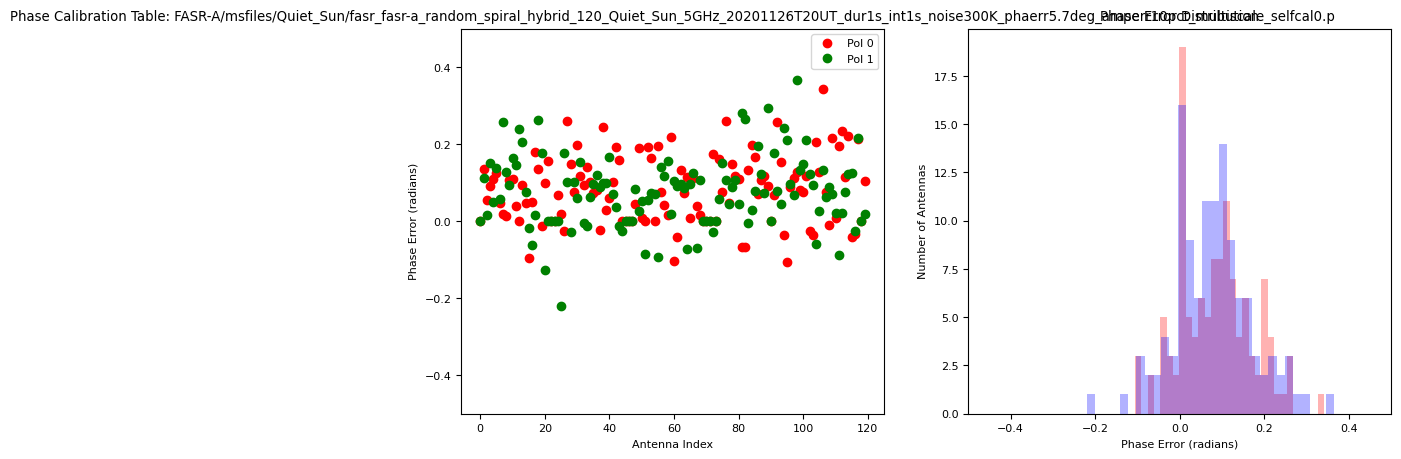

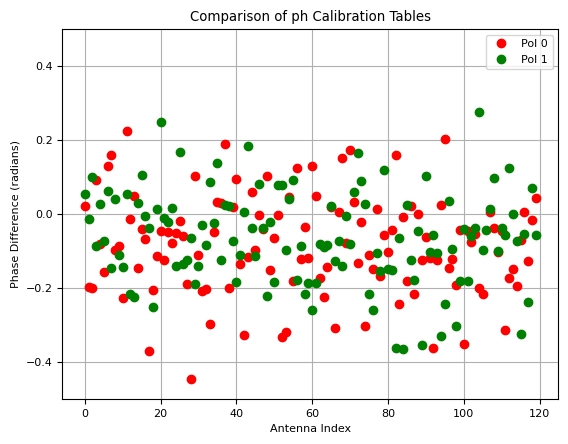

Comparing initial calibration table FASR-A/caltbs/caltb_FASR_corrupt_6deg.ph with self-calibration table 2 FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_selfcal0.p:


In [194]:
reload(fss)
fss.plot_caltb_stats([cal_table_selfcal_p], caltype='ph', yrange=[-0.5, 0.5])
fss.compare_two_gaintables(gaintable[0], cal_table_selfcal_p, caltype='ph', yrange=[-0.5, 0.5])
print(f'Comparing initial calibration table {gaintable[0]} with self-calibration table 2 {cal_table_selfcal_p}:')

Start plotting
Applying a mask of 1.3 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_nonoise_clean.image: 3.038e+05 K
rms of fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr5.7deg_amperr10pct_multiscale_nonoise_clean.image (excluding solar disk): 1.947e+03 K
SNR of the image: 156.1
Peak of solar_disk_model_20201126.5GHz.masked.im: 3.226e+05 K
rms of solar_disk_model_20201126.5GHz.masked.im (excluding solar disk): 5.104e-03 K
Plotting image with vmin=-1.947e+04 K, vmax=1.519e+05 K
Plotting convolved image with vmin=-1.947e+04 K, vmax=1.519e+05 K


/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2880: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2925: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)


'plot_two_casa_images_with_convolution' completed at 2026-02-05 15:06:13; runtime: 0.48 seconds


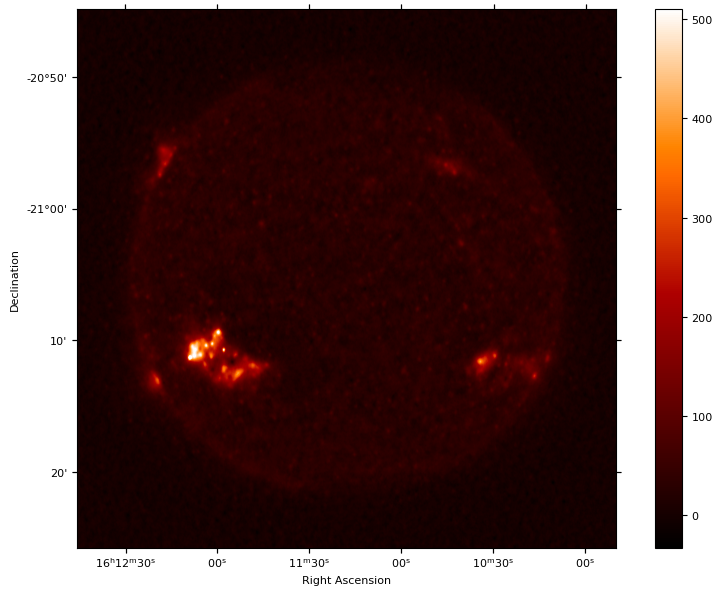

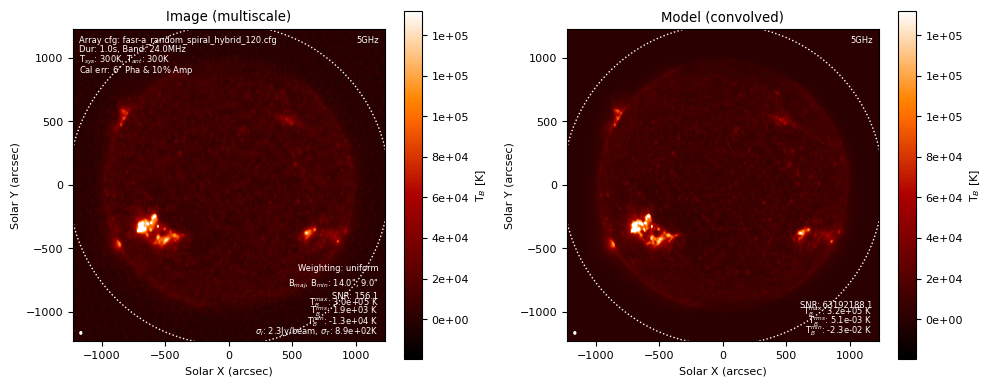

In [200]:
# make an image from the noise-free MS for comparison
imname_clean_nonoise = imname + '_nonoise_clean'
if not os.path.exists(f'{imname_clean_nonoise}.image'):
    clearcal(vis=msfile)
    tclean(vis=msfile,
           imagename=imname_clean_nonoise,
           imsize=imsize_target,
           cell=cell_target,
           weighting=weighting,
           deconvolver='multiscale', scales=scale_init, 
           gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
           niter=10000,
           interactive=False,
           savemodel='none')
    # clean up intermediate files
    for suffix in ['.model', '.residual', '.psf', '.flux',
                     '.mask', '.pb', '.image.pbcor', '.sumwt']:
          file_to_remove = f'{imname_clean_nonoise}{suffix}'
          if os.path.exists(file_to_remove):
                os.system(f'rm -rf {file_to_remove}')
            
fss.plot_casa_image(imname_clean_nonoise + '.image', cmap='hinodexrt')
#fss.plot_casa_image(imname_clean + '.image', cmap='hinodexrt')
image1 = imname_clean_nonoise + '.image'
## model image
image2 = os.path.join(project+'/msfiles/Quiet_Sun/', os.path.basename(solar_model.replace('.fits', '.im')))
image_meta = {'title': [f'Image ({deconvolver})', 'Model (convolved)'],
              'freq': freq_target.lstrip("0"),
              'array_config': config_file,
              'tsys': f'{tsys:.0f}K',
              'tant': f'{tant:.0f}K',
              'sigma_jy': f'{sigma_jy:.1f}Jy/beam',
              'cal_error': f'{phaerr_deg:.0f}'+r'$^{\circ}$ Pha' + f' & {np.int_(amperr * 100)}% Amp',
              'duration': f'{duration}s',
              'bandwidth': f'{channel_width_mhz}MHz',
              'weighting': weighting,
              }
print('Start plotting')
fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                     crop_fraction=(0.0, 1.0),
                                                     #crop_fraction=((0.17, 0.37), (0.25, 0.45)),
                                                     rms_mask_radius=1.3,
                                                     reftime=reftime,
                                                     figsize=(15, 4),
                                                     image_meta=image_meta,
                                                     cmap='hinodexrt',
                                                     vmax=50,
                                                     compare_two=False,
                                                     contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4,
                                                                     0.8],
                                                     conv_tag=f'.{cfg_suffix}',
                                                     overwrite_conv=False)

In [119]:
# Now supply the inital image from the 2 GHz as the model image for self-calibration
imname_init_model = imname_init + '.image'
# Make a copy of the corrupted MS to perform self-calibration
ms_selfcal = ms_corrupted.replace('.ms', '_selfcal.ms')
if not os.path.exists(ms_selfcal):
    os.system(f'cp -r {ms_corrupted} {ms_selfcal}')
    print('Created copy of MS for self-calibration:', ms_selfcal)

# Modify the model image to have the same freq as the target ms visibility
# first make a copy of the initial model image
command = f"cp -r {imname_init_model} {imname_init_model.replace('.image', f'_{freq_target}model.image')}"
os.system(command)
imname_init_model = imname_init_model.replace('.image', f'_{freq_target}model.image')

# Get frequency information from the target MS
from casatools import msmetadata
msmd = msmetadata()
msmd.open(ms_selfcal)
new_freq_hz = msmd.reffreq(0)['m0']['value']
msmd.done()

# Now change the frequency axis of the model image to match the target frequency
from casatools import image
ia = image()
ia.open(imname_init_model)
csys = ia.coordsys()

# Get current reference values
refval = csys.referencevalue()['numeric']
# Update the frequency axis (index 3) to the new frequency
refval[3] = new_freq_hz

# KEY STEP: You must use setreferencevalue to update the csys object
csys.setreferencevalue(refval)

# Save the updated coordinate system to the image
ia.setcoordsys(csys.torecord())
ia.done()
print(f'Updated model image frequency to {new_freq_hz/1e9:.3f} GHz')


Created copy of MS for self-calibration: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_corrupt_selfcal.ms
Updated model image frequency to 5.000 GHz


In [120]:
# Put the model image into the model column of the MS
from casatasks import ft
ft(vis=ms_selfcal, spw='0', model=imname_init_model, usescratch=False)

In [121]:
from casatasks import gaincal
# Perform phase-only self-calibration
cal_table_selfcal = imname + '_selfcal0.ap'
uvrange = '<20klambda' # exclude longest baselines for self-calibration to avoid overfitting noise
if not os.path.exists(cal_table_selfcal):
    gaincal(vis=ms_selfcal,
            caltable=cal_table_selfcal,
            uvrange=uvrange,
            solint='inf',
            calmode='ap',
            gaintype='G',
            refant='',
            minblperant=4,
            minsnr=3.0)
    print('Self-calibration gain table created:', cal_table_selfcal)

75 of 232 solutions flagged due to SNR < 3 in spw=0 at 2020/11/26/19:25:52.7
Self-calibration gain table created: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal0.ap


Opening calibration table: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal0.ap
Shape of the data in FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal0.ap: (2, 1, 120)


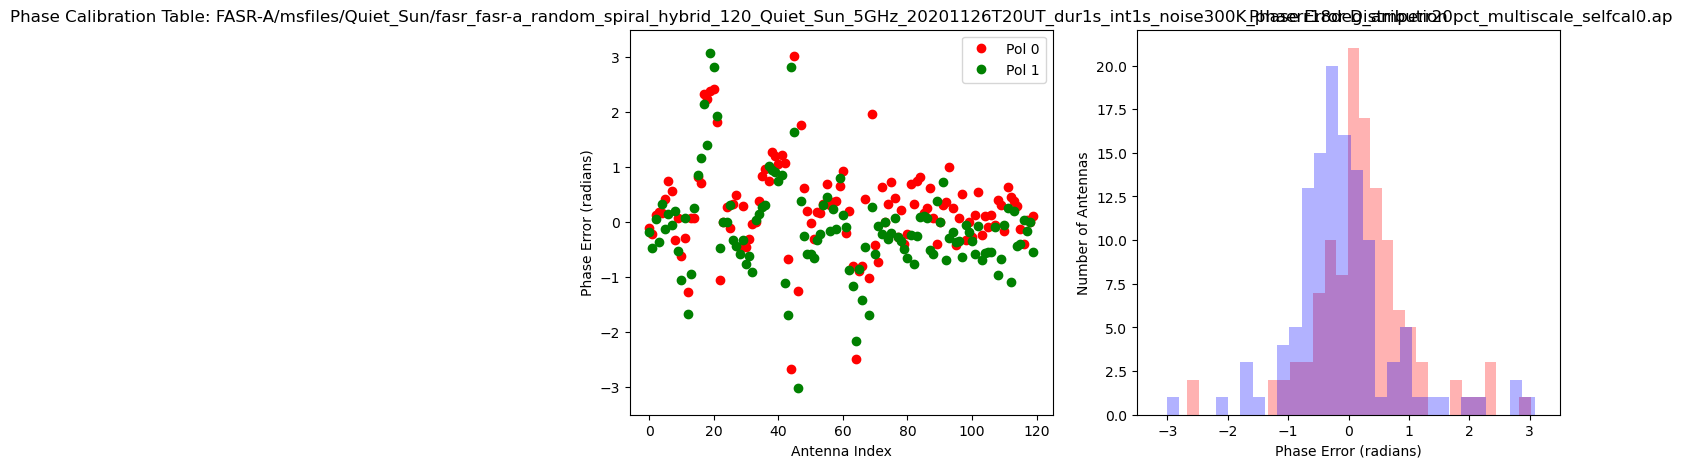

Opening calibration table: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal0.ap
Shape of the data in FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal0.ap: (2, 1, 120)


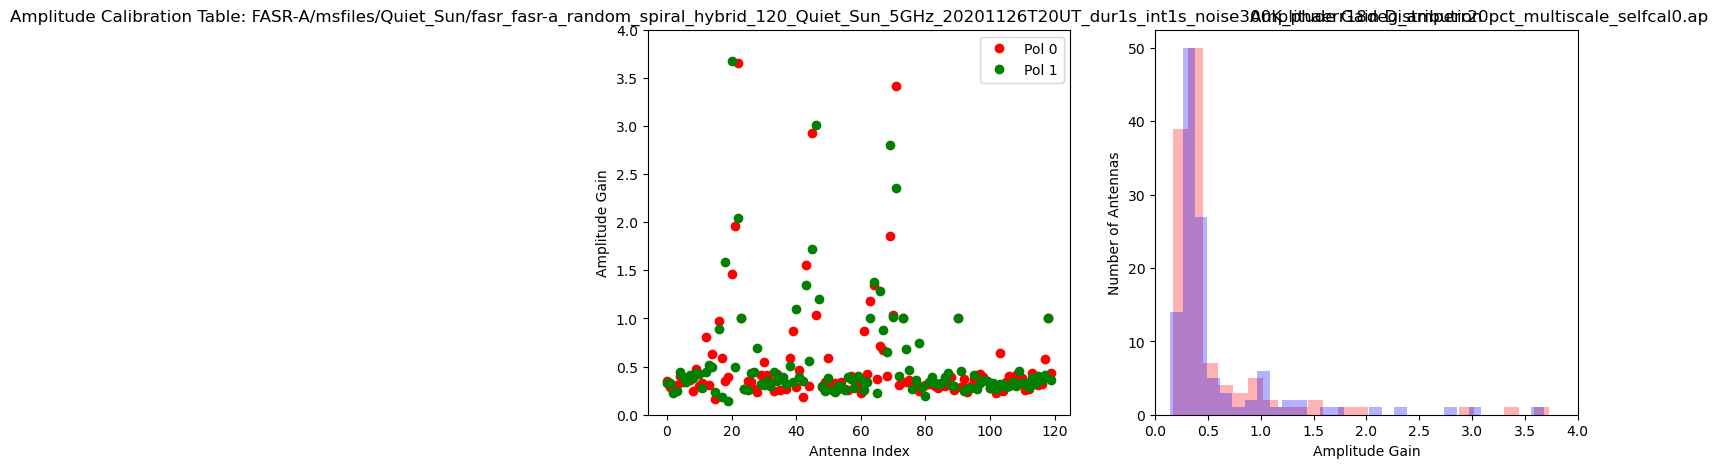

In [123]:
reload(fss)
fss.plot_caltb_stats([cal_table_selfcal], caltype='ph', yrange=[-3.5, 3.5])
fss.plot_caltb_stats([cal_table_selfcal], caltype='amp', yrange=[0, 4])

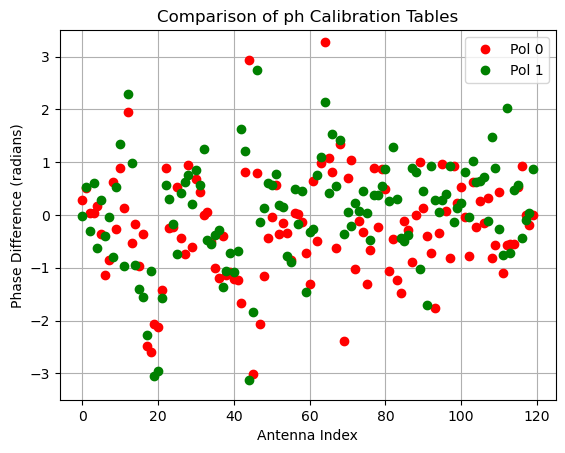

Comparing initial calibration table FASR-A/caltbs/caltb_FASR_corrupt_18deg.ph with self-calibration table 2 FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal0.ap:


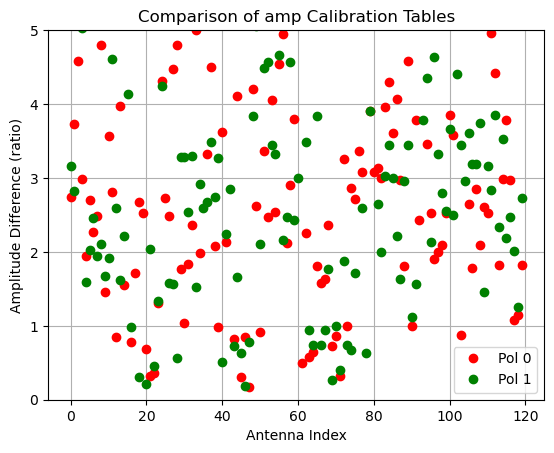

Comparing initial calibration table FASR-A/caltbs/caltb_FASR_corrupt_20pct.amp with self-calibration table 2 FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal0.ap:


In [124]:
reload(fss)
fss.compare_two_gaintables(gaintable[0], cal_table_selfcal, caltype='ph', yrange=[-3.5, 3.5])
print(f'Comparing initial calibration table {gaintable[0]} with self-calibration table 2 {cal_table_selfcal}:')
fss.compare_two_gaintables(gaintable[1], cal_table_selfcal, caltype='amp', yrange=[0, 5])
print(f'Comparing initial calibration table {gaintable[1]} with self-calibration table 2 {cal_table_selfcal}:')

Created copy of MS for applying self-calibration: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_corrupt_selfcal_selfcal_applied.ms


2026-02-05 15:00:46	WARN	calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
2026-02-05 15:00:46	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-05 15:00:46	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-05 15:00:46	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 
2026-02-05 15:00:47	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Self-calibrated dirty image created: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal_dirty
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal_dirty.model
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal_dirty.residual
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal_dirty.psf
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal_dirty.pb


(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

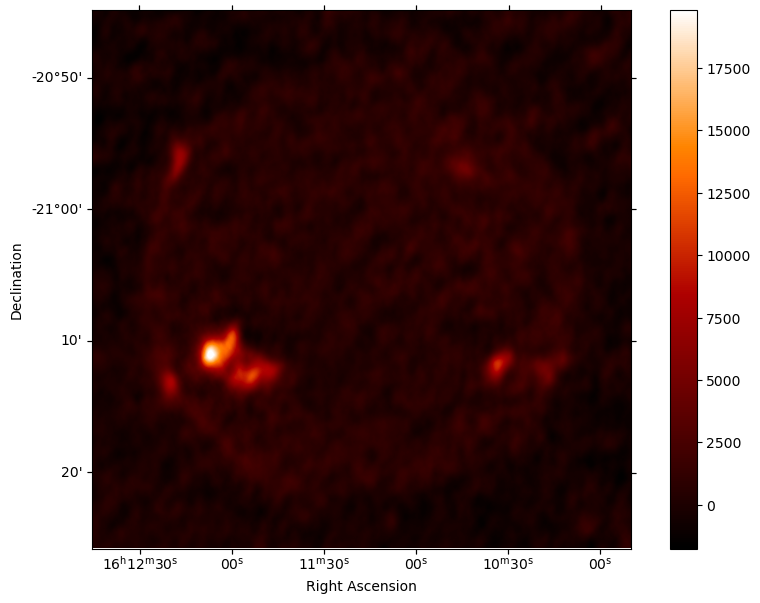

In [125]:
# Apply the self-calibration solutions to the MS
from casatasks import applycal
ms_selfcal_applied = ms_selfcal.replace('.ms', '_selfcal_applied.ms')
if not os.path.exists(ms_selfcal_applied):
    os.system(f'cp -r {ms_selfcal} {ms_selfcal_applied}')
    print('Created copy of MS for applying self-calibration:', ms_selfcal_applied)
    clearcal(vis=ms_selfcal_applied)
    applycal(vis=ms_selfcal_applied,
             gaintable=[cal_table_selfcal],
             applymode='calonly',
             calwt=False)
# make a dirty image from the self-calibrated MS
imname_selfcal_dirty = imname.replace(deconvolver, 'selfcal_dirty')
if not os.path.exists(f'{imname_selfcal_dirty}.image'):
    tclean(vis=ms_selfcal_applied,
           imagename=imname_selfcal_dirty,
           imsize=imsize_target,
           cell=cell_target,
           weighting=weighting,
           deconvolver='hogbom',
           niter=0,
           interactive=False,
           savemodel='none')
    print('Self-calibrated dirty image created:', imname_selfcal_dirty)
    # clean up intermediate files
    for suffix in ['.model', '.residual', '.psf', '.flux',
                     '.mask', '.pb', '.image.pbcor', 'sumwt']:
          file_to_remove = f'{imname_selfcal_dirty}{suffix}'
          if os.path.exists(file_to_remove):
                os.system(f'rm -rf {file_to_remove}')
                print('Removed intermediate file:', file_to_remove)
            
fss.plot_casa_image(imname_selfcal_dirty + '.image', cmap='hinodexrt')

2026-02-05 15:01:10	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-05 15:01:10	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-05 15:01:10	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 


Self-calibrated clean image created: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal0_clean
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal0_clean.model
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal0_clean.mask
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal0_clean.pb
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal0_clean.psf
Removed intermediate file: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral

(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

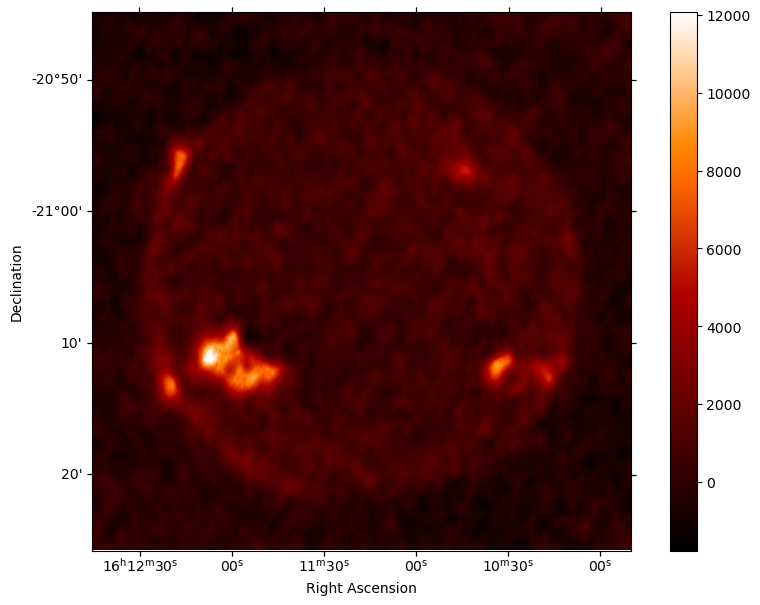

In [126]:
# Now do a shallow clean on the self-calibrated MS
imname_selfcal = imname.replace(deconvolver, 'selfcal0_clean')
if not os.path.exists(f'{imname_selfcal}.image'):
    tclean(vis=ms_selfcal_applied,
           imagename=imname_selfcal,
           imsize=imsize_target,
           cell=cell_target,
           uvrange=uvrange,
           weighting=weighting,
           deconvolver='hogbom',
           niter=400,
           savemodel='none',
           interactive=False)
    print('Self-calibrated clean image created:', imname_selfcal)
    # clean up intermediate files
    for suffix in ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']:
          file_to_remove = f'{imname_selfcal}{suffix}'
          if os.path.exists(file_to_remove):
                os.system(f'rm -rf {file_to_remove}')
                print('Removed intermediate file:', file_to_remove)
            
fss.plot_casa_image(imname_selfcal + '.image', cmap='hinodexrt')

Opening calibration table: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal1.ap
Shape of the data in FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal1.ap: (2, 1, 120)


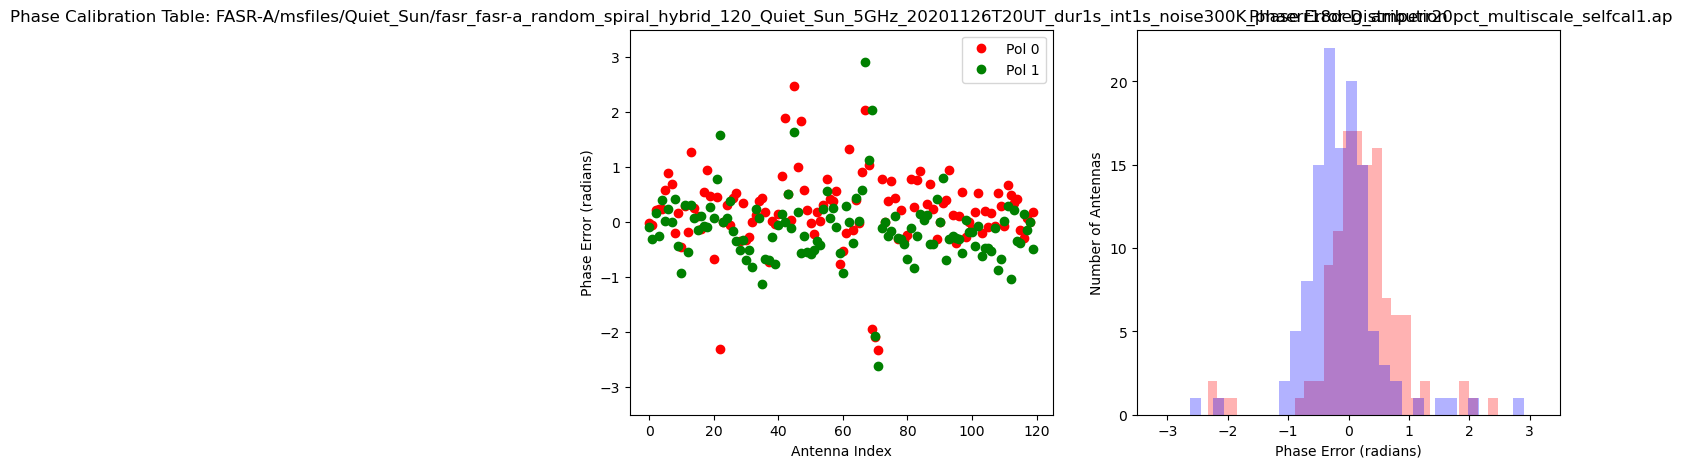

Opening calibration table: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal1.ap
Shape of the data in FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal1.ap: (2, 1, 120)


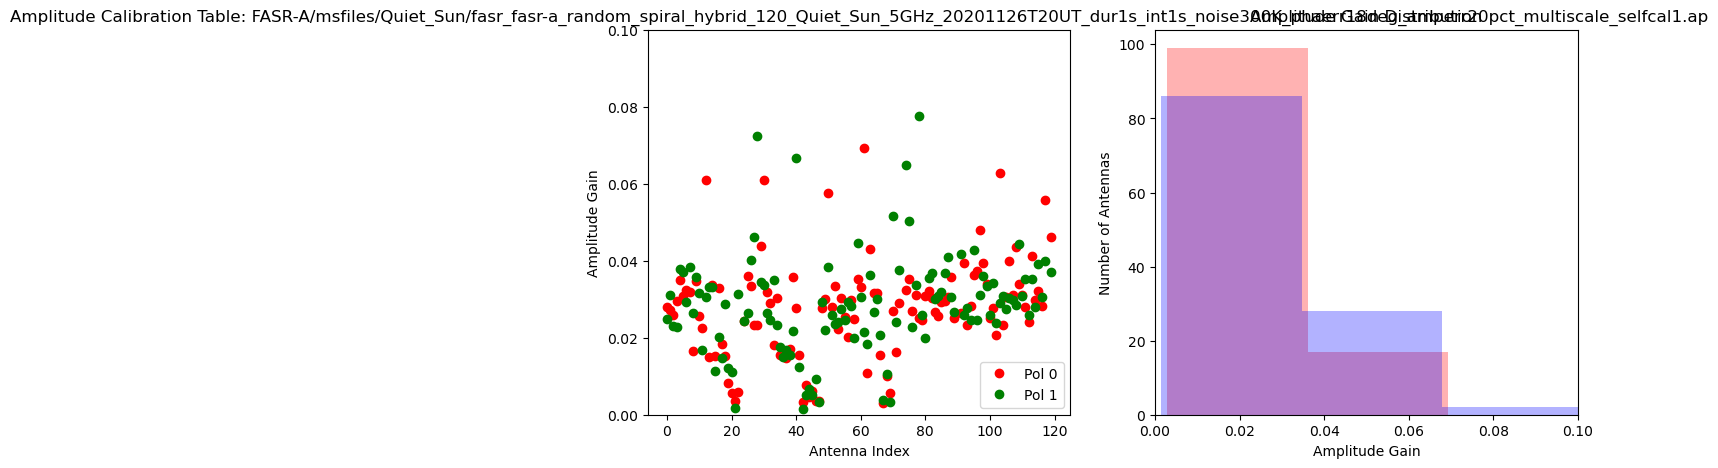

In [130]:
# Now do another round of self-calibration using the shallow cleaned image as the model
# Put the model image into the model column of the MS
gaincal_table_selfcal2 = imname + '_selfcal1.ap'
uvrange = '<20klambda' # exclude longest baselines for self-calibration to avoid overfitting noise
if not os.path.exists(gaincal_table_selfcal2):
    print(f'Selfcalibrating using {ms_selfcal} and model from {imname_selfcal}.image')
    clearcal(vis=ms_selfcal)
    ft(vis=ms_selfcal, spw='0', model=imname_selfcal + '.image', usescratch=False)
    gaincal(vis=ms_selfcal,
            caltable=gaincal_table_selfcal2,
            uvrange=uvrange,
            solint='inf',
            calmode='ap',
            gaintype='G',
            refant='',
            minblperant=4,
            minsnr=3.0)
    print('Self-calibration gain table created:', gaincal_table_selfcal2)

fss.plot_caltb_stats([gaincal_table_selfcal2], caltype='ph', yrange=[-3.5, 3.5])
fss.plot_caltb_stats([gaincal_table_selfcal2], caltype='amp', yrange=[0, 0.1])


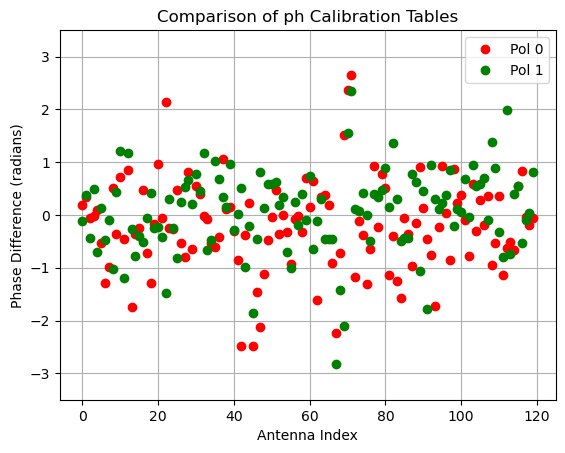

Comparing initial calibration table FASR-A/caltbs/caltb_FASR_corrupt_18deg.ph with self-calibration table 2 FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal1.ap:


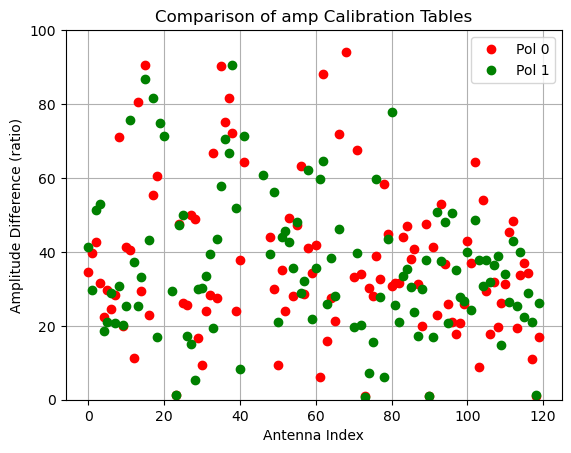

Comparing initial calibration table FASR-A/caltbs/caltb_FASR_corrupt_20pct.amp with self-calibration table 2 FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_multiscale_selfcal1.ap:


In [131]:
reload(fss)
fss.compare_two_gaintables(gaintable[0], gaincal_table_selfcal2, caltype='ph', yrange=[-3.5, 3.5])
print(f'Comparing initial calibration table {gaintable[0]} with self-calibration table 2 {gaincal_table_selfcal2}:')
fss.compare_two_gaintables(gaintable[1], gaincal_table_selfcal2, caltype='amp', yrange=[0, 100])
print(f'Comparing initial calibration table {gaintable[1]} with self-calibration table 2 {gaincal_table_selfcal2}:')

2026-02-05 15:05:03	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Did not get the position of FASR from data repository
2026-02-05 15:05:03	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Please contact CASA to add it to the repository.
2026-02-05 15:05:03	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2501)	Using first antenna position as refence 


Self-calibrated dirty image created: FASR-A/msfiles/Quiet_Sun/fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_5GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr18deg_amperr20pct_selfcal2_clean


(<Figure size 1000x700 with 2 Axes>, <WCSAxes: >)

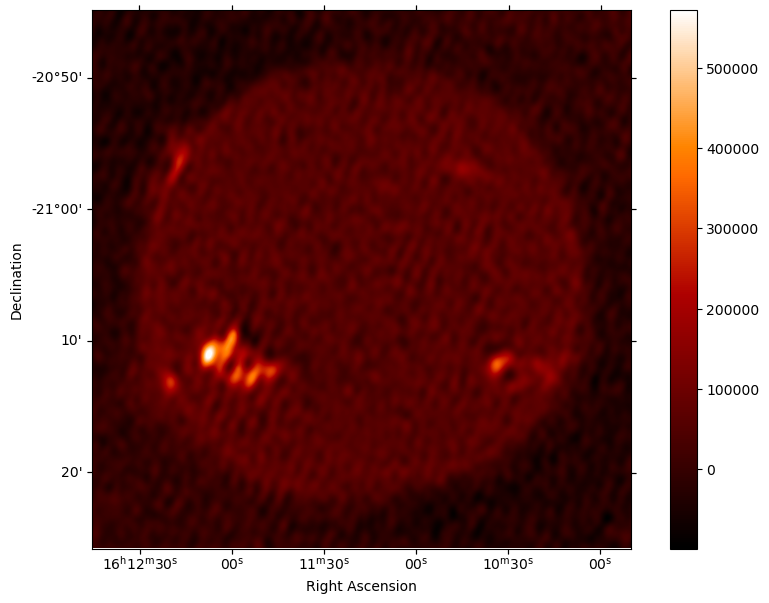

In [134]:
# Apply the self-calibration solutions to the MS
ms_selfcal_applied2 = ms_selfcal.replace('.ms', '_selfcal2_applied.ms')
if not os.path.exists(ms_selfcal_applied2):
    os.system(f'cp -r {ms_selfcal} {ms_selfcal_applied2}')
    print('Created copy of MS for applying self-calibration:', ms_selfcal_applied2)
    clearcal(vis=ms_selfcal_applied2)
    applycal(vis=ms_selfcal_applied2,
             gaintable=[gaincal_table_selfcal2],
             applymode='calonly',
             calwt=False)
# make a dirty image from the self-calibrated MS
imname_selfcal2 = imname.replace(deconvolver, 'selfcal2_clean')
if not os.path.exists(f'{imname_selfcal2}.image'):
    tclean(vis=ms_selfcal_applied2,
           imagename=imname_selfcal2,
           imsize=imsize_target,
           cell=cell_target,
           weighting=weighting,
           deconvolver='multiscale', scales=scale_init, 
           gain=0.1, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
           #deconvolver='hogbom',
           niter=2000,
           interactive=False,
           savemodel='none')
    print('Self-calibrated dirty image created:', imname_selfcal2)
    # clean up intermediate files
    for suffix in ['.model', '.residual', '.psf', '.flux',
                     '.mask', '.pb', '.image.pbcor', '.sumwt']:
          file_to_remove = f'{imname_selfcal2}{suffix}'
          if os.path.exists(file_to_remove):
                os.system(f'rm -rf {file_to_remove}')
            
fss.plot_casa_image(imname_selfcal2 + '.image', cmap='hinodexrt')
            